In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm
import copy
import os
import warnings
from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
def create_balanced_sampler(dataset):
    """
    Create a weighted sampler to balance class distribution in the dataset
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset to sample from
    
    Returns:
        WeightedRandomSampler: A sampler that balances class distribution
    """
    # Count the number of samples per class
    class_counts = {}
    for _, label in dataset.samples:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    
    # Calculate weights inversely proportional to class frequency
    num_classes = len(class_counts)
    num_samples = len(dataset)
    
    # Print class distribution for transparency
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/num_samples*100:.2f}%)")
    
    # Calculate sample weights
    weights = [0.0] * num_samples
    for idx, (_, label) in enumerate(dataset.samples):
        # Compute weight as (total samples / (num_classes * samples in this class))
        weights[idx] = num_samples / (num_classes * class_counts[label])
    
    # Convert to tensor
    sample_weights = torch.DoubleTensor(weights)
    
    return WeightedRandomSampler(sample_weights, len(sample_weights))

In [5]:
# Define less aggressive data transformations with reduced image size
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1)),
    transforms.RandomRotation([-10, 10]),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Updated normalization for grayscale
])

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Updated normalization for grayscale
])
# Load dataset with correct transformations
train_data = datasets.ImageFolder(
    "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", 
    transform=train_transforms
)

validation_data = datasets.ImageFolder(
    "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", 
    transform=val_transforms
)

# Create balanced sampler
sampler = create_balanced_sampler(train_data)

# DataLoader configuration
loaded_train = DataLoader(
    train_data, 
    batch_size=64, 
    sampler=sampler, 
    num_workers=4, 
    pin_memory=True
)

loaded_validation = DataLoader(
    validation_data, 
    batch_size=64, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# Optional: Print dataset details
print(f"\nTotal Training Samples: {len(train_data)}")
print(f"Total Validation Samples: {len(validation_data)}")
print(f"Number of Classes: {len(train_data.classes)}")
print("Class Names:", train_data.classes)

Class Distribution:
Class 0: 3993 samples (13.85%)
Class 1: 436 samples (1.51%)
Class 2: 4103 samples (14.24%)
Class 3: 7164 samples (24.86%)
Class 4: 4982 samples (17.29%)
Class 5: 4938 samples (17.13%)
Class 6: 3205 samples (11.12%)

Total Training Samples: 28821
Total Validation Samples: 7066
Number of Classes: 7
Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class ImprovedEmotionDNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ImprovedEmotionDNN, self).__init__()
        
        # Input layer normalization
        self.input_norm = nn.BatchNorm1d(64 * 64)
        
        # Main network architecture with residual connections
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 7)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.network(x)
        return x

# Create model instance
model = ImprovedEmotionDNN().to(device)

# Improved optimizer configuration
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0005,  # Lower initial learning rate
    weight_decay=0.01,  # Increased weight decay for better regularization
    betas=(0.9, 0.999),
    eps=1e-8
)

# Improved learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=100,
    steps_per_epoch=len(loaded_train),
    pct_start=0.2,  # Longer warmup
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

Starting training...
Epoch [1/100] Batch [440/451] Loss: 1.8955 LR: 0.000121
Epoch [1/100]
Train Loss: 1.9144, Train Acc: 19.93%
Val Loss: 1.8982, Val Acc: 22.37%
Per-class accuracies: {0: '5.94%', 1: '27.93%', 2: '4.13%', 3: '16.55%', 4: '28.12%', 5: '17.65%', 6: '76.04%'}
Epoch [2/100] Batch [440/451] Loss: 1.9917 LR: 0.000184
Epoch [2/100]
Train Loss: 1.8813, Train Acc: 24.32%
Val Loss: 1.8452, Val Acc: 27.70%
Per-class accuracies: {0: '6.04%', 1: '32.43%', 2: '8.55%', 3: '39.34%', 4: '30.10%', 5: '16.77%', 6: '62.86%'}
Epoch [3/100] Batch [440/451] Loss: 1.8428 LR: 0.000283
Epoch [3/100]
Train Loss: 1.8645, Train Acc: 26.07%
Val Loss: 1.8531, Val Acc: 26.54%
Per-class accuracies: {0: '0.73%', 1: '51.35%', 2: '2.46%', 3: '32.82%', 4: '27.14%', 5: '24.85%', 6: '72.02%'}
Epoch [4/100] Batch [440/451] Loss: 1.8906 LR: 0.000408
Epoch [4/100]
Train Loss: 1.8584, Train Acc: 26.61%
Val Loss: 1.8221, Val Acc: 29.30%
Per-class accuracies: {0: '13.44%', 1: '45.05%', 2: '2.55%', 3: '41.04%', 4

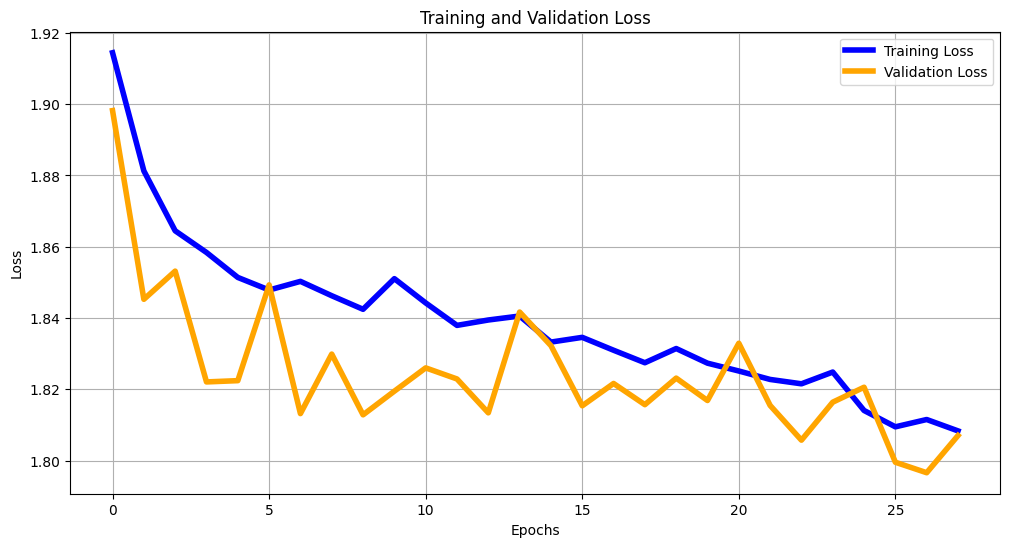

In [7]:
# Validation loss calculation
def compute_validation_loss():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loaded_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loaded_validation)

# Initialize model, loss, and optimizer with better configurations
model = EmotionDNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Increased label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05, betas=(0.9, 0.999))  # Lower initial LR, higher weight decay

# More sophisticated learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=100,
    steps_per_epoch=len(loaded_train),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=100.0
)

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

# Initialize loss tracking with early stopping
train_losses = []
val_losses = []
best_val_acc = 0
patience = 15  # Increased patience
patience_counter = 0
best_model_state = None

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 7
    class_total = [0] * 7
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast("cuda"):
                outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            for i in range(7):
                mask = labels == i
                class_correct[i] += (predicted[mask] == labels[mask]).sum().item()
                class_total[i] += mask.sum().item()
    
    return 100 * correct / total, [100 * c/t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

def train_part(model, optimizer, epochs=100):
    global best_val_acc, patience_counter, best_model_state
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(loaded_train):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Clear gradients
            for param in model.parameters():
                param.grad = None
            
            # Mixed precision training
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Gradient scaling and optimization
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Update LR each batch
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 20 == 0:  # Print progress every 20 batches
                print(f'Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(loaded_train)}] '
                      f'Loss: {loss.item():.4f} LR: {scheduler.get_last_lr()[0]:.6f}', end='\r')
        
        # Calculate metrics
        train_loss = running_loss / len(loaded_train)
        train_acc = 100 * correct / total
        val_loss = compute_validation_loss()
        val_acc, class_accs = evaluate_model(model, loaded_validation)
        
        # Save losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
        else:
            patience_counter += 1
        
        # Print epoch statistics
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("Per-class accuracies:", {k: f"{v:.2f}%" for k, v in enumerate(class_accs)})
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
        
        # Clear GPU cache periodically
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
    
    # Plot training history with improved visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 1, 1)
    plt.plot(train_losses, label="Training Loss", color='blue', linewidth=4)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=4)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Training and Validation Loss")
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
    return model

print("Starting training...")
model = train_part(model, optimizer)
print("Training complete!")

# Final evaluation
val_accuracy, class_accuracies = evaluate_model(model, loaded_validation)
print(f'Final Validation Accuracy: {val_accuracy:.2f}%')
print("Per-class accuracies:", {k: f"{v:.2f}%" for k, v in enumerate(class_accuracies)})



Target label: disgust


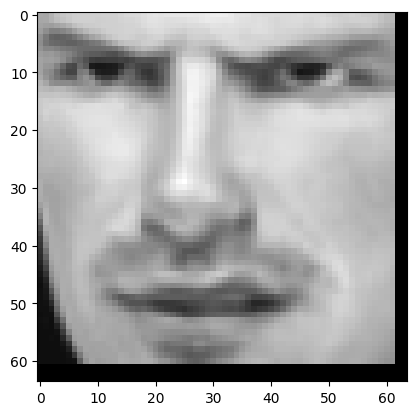

In [8]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


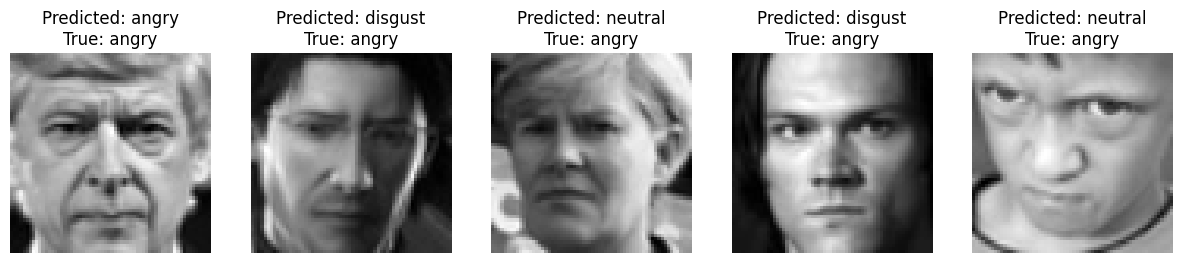

In [9]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()